# Plotting

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `/global/u2/j/jaimerz/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [35]:
Nside = 64
d = 3 * Nside^2 + 2
T = Float64;
prob = load_cmb_lensing_problem(;storage=Array, T, Nside, masking=true, global_parameters=false);

In [5]:
function get_mask_distance(prob)
    prob.ds.M isa LazyBinaryOp || error("masking must be enabled")
    mx = diag(prob.ds.M[2])[:Qx] .== 1;
    nearest = getfield.(@eval(CMBLensing,@ondemand(ImageMorphology.feature_transform))(mx), :I)
    Ny, Nx = size(mx)
    return [norm(nearest[i,j] .- [i,j]) for i=1:Ny,j=1:Nx]
end

get_mask_distance (generic function with 1 method)

In [6]:
dist_mat = get_mask_distance(prob);

## Samples

In [7]:
function make_chain(samples::AbstractMatrix)
    return Chains(permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf])
end    

make_chain (generic function with 1 method)

In [8]:
unmasked_mchmc_samples = load("../chains/MCHMC/CMBLensing_unmasked_Nside_64_TEV_0.0001", "samples")
unmasked_hmc_samples = load("../chains/HMC/CMBLensing_unmasked_Nside_64_ϵ_0.25", "_samples_hmc")
unmasked_muse_chain = load("../chains/MUSE/CMBLensing_unmasked_Nside_64", "chain_muse");

unmasked_no_cosmo_mchmc_chain = load("../chains/MCHMC/CMBLensing_no_cosmo_unmasked_TEV_0.0001", "samples");
unmasked_no_cosmo_hmc_chain = load("../chains/HMC/CMBLensing_unmasked_no_cosmo_Nside_64_ϵ_0.25", "_samples_hmc");

In [9]:
masked_mchmc_samples = load("../chains/MCHMC/CMBLensing_masked_TEV_0.0001", "samples")
masked_pp_mchmc_samples = load("../chains/MCHMC/CMBLensing_masked_pp_Nside_64_TEV_0.0001", "samples");
masked_hmc_samples = load("../chains/HMC/CMBLensing_masked_Nside_64_ϵ_0.25", "_samples_hmc");
masked_muse_chain = load("../chains/MUSE/CMBLensing_masked_Nside_64", "chain_muse");

masked_no_cosmo_hmc_chain = load("../chains/HMC/CMBLensing_masked_no_cosmo_Nside_64_ϵ_0.25", "_samples_hmc");
masked_no_cosmo_mchmc_chain = load("../chains/MCHMC/CMBLensing_masked_no_cosmo_Nside_64_TEV_0.0001", "samples");
masked_pp_no_cosmo_mchmc_chain = load("../chains/MCHMC/CMBLensing_masked_pp_no_cosmo_Nside_64_TEV_0.0001", "samples");

In [10]:
unmasked_mchmc_chain = make_chain(unmasked_mchmc_samples);
masked_mchmc_chain = make_chain(masked_mchmc_samples);
masked_pp_mchmc_chain = make_chain(masked_pp_mchmc_samples);

## Unmasked

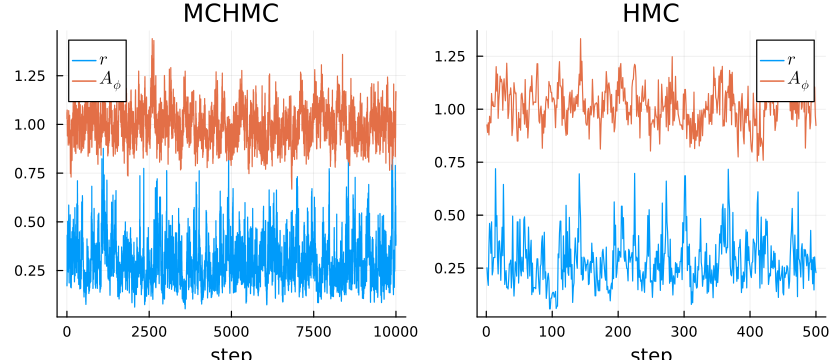

In [11]:
plot(
    begin
        plot(unmasked_mchmc_chain[:r], label=L"r", xlabel="step", title="MCHMC")
        plot!(unmasked_mchmc_chain[:Aϕ], label=L"A_\phi")
    end, 
    begin
        plot(exp.(unmasked_hmc_samples[:, end-1]), label=L"r", xlabel="step", title="HMC")
        plot!(exp.(unmasked_hmc_samples[:, end]), label=L"A_\phi")
    end, 
    size = (700, 300)
)

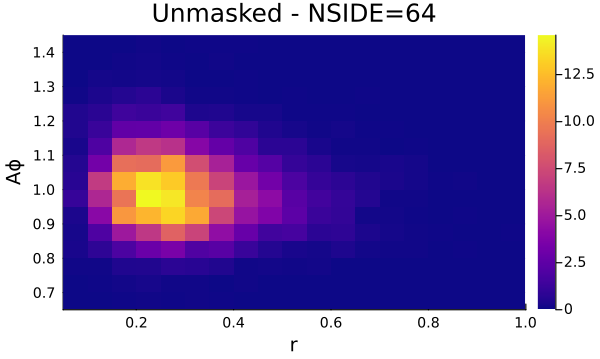

In [12]:
histogram2d(unmasked_mchmc_chain[:r], unmasked_mchmc_chain[:Aϕ], bins=(20, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Unmasked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

In [13]:
unmasked_vars = var(unmasked_mchmc_samples, dims=2)[1:d]
_unmasked_vars = var(unmasked_mchmc_samples, dims=2)[d+1:2*d];

LoadError: UndefVarError: `d` not defined

In [14]:
unmasked_k = round(maximum(unmasked_vars)/minimum(unmasked_vars), digits=2)
_unmasked_k = round(maximum(_unmasked_vars)/minimum(_unmasked_vars), digits=2);

LoadError: UndefVarError: `unmasked_vars` not defined

In [15]:
plot(_unmasked_vars, title="Diag(cov) - Unmasked", label=string("Latent space --> K = ", _unmasked_k))
plot!(unmasked_vars, label=string("Parameter space --> K = ", unmasked_k))

LoadError: UndefVarError: `_unmasked_k` not defined

In [16]:
using CMBLensing: fit, Histogram, Weights
_unmasked_vars_q = _unmasked_vars[1:Int((d-2)/3)]
_unmasked_vars_u = _unmasked_vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

LoadError: UndefVarError: `_unmasked_vars` not defined

In [17]:
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_unmasked_vars_q), range(0,13,length=20)).weights
hist_vars_q ./= fit(Histogram, vec(dist_mat), Weights(ones(length(_unmasked_vars_q))), range(0,13,length=20)).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_unmasked_vars_u), range(0,13,length=20)).weights
hist_vars_u ./= fit(Histogram, vec(dist_mat), Weights(ones(length(_unmasked_vars_q))), range(0,13,length=20)).weights
plot(0.0:0.6842105263157895:13.0, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field",
     title="Unmasked")
plot!(0.0:0.6842105263157895:13.0, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field")

LoadError: UndefVarError: `_unmasked_vars_q` not defined

## Masked

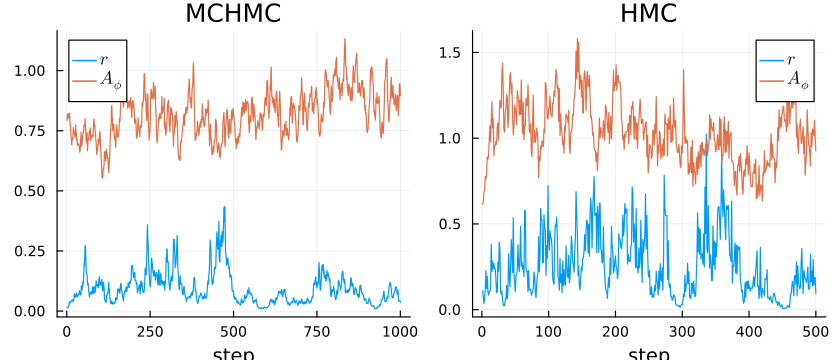

In [18]:
plot(
    begin
        plot(masked_mchmc_chain[:r], label=L"r", xlabel="step", title="MCHMC")
        plot!(masked_mchmc_chain[:Aϕ], label=L"A_\phi")
    end, 
    begin
        plot(exp.(masked_hmc_samples[:, end-1]), label=L"r", xlabel="step", title="HMC")
        plot!(exp.(masked_hmc_samples[:, end]), label=L"A_\phi")
    end, 
    size = (700, 300)
)

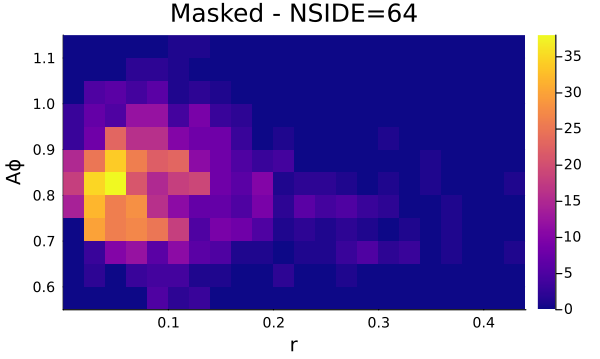

In [19]:
histogram2d(masked_mchmc_chain[:r], masked_mchmc_chain[:Aϕ], bins=(20, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

In [36]:
masked_vars = var(masked_mchmc_samples, dims=2)[1:d]
_masked_vars = var(masked_mchmc_samples, dims=2)[d+1:2*d];

masked_pp_vars = var(masked_pp_mchmc_samples, dims=2)[1:d]
_masked_pp_vars = var(masked_pp_mchmc_samples, dims=2)[d+1:2*d];

In [37]:
masked_k = round(maximum(masked_vars)/minimum(masked_vars), digits=2)
_masked_k = round(maximum(_masked_vars)/minimum(_masked_vars), digits=2)

masked_pp_k = round(maximum(masked_pp_vars)/minimum(masked_pp_vars), digits=2)
_masked_pp_k = round(maximum(_masked_pp_vars)/minimum(_masked_pp_vars), digits=2)

61.08

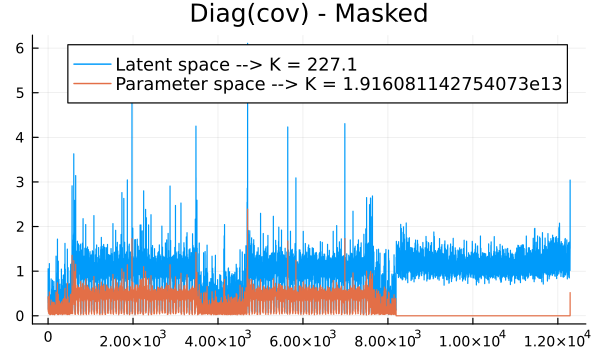

In [38]:
plot(_masked_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _masked_k))
plot!(masked_vars, label=string("Parameter space --> K = ", masked_k))

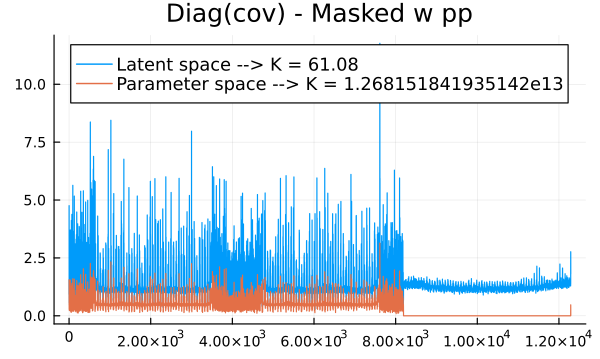

In [39]:
plot(_masked_pp_vars, title="Diag(cov) - Masked w pp", label=string("Latent space --> K = ", _masked_pp_k))
plot!(masked_pp_vars, label=string("Parameter space --> K = ", masked_pp_k))

In [40]:
using CMBLensing: fit, Histogram, Weights
_masked_vars_q = _masked_vars[1:Int((d-2)/3)]
_masked_vars_u = _masked_vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

_masked_pp_vars_q = _masked_pp_vars[1:Int((d-2)/3)]
_masked_pp_vars_u = _masked_pp_vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

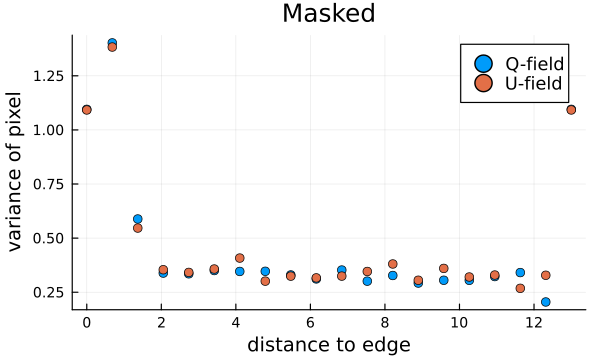

In [41]:
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_masked_vars_q), range(0,13,length=20)).weights
hist_vars_q ./= fit(Histogram, vec(dist_mat), Weights(ones(length(_masked_vars_q))), range(0,13,length=20)).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_masked_vars_u), range(0,13,length=20)).weights
hist_vars_u ./= fit(Histogram, vec(dist_mat), Weights(ones(length(_masked_vars_q))), range(0,13,length=20)).weights
plot(0.0:0.6842105263157895:13.0, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field",
     title="Masked")
plot!(0.0:0.6842105263157895:13.0, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field")

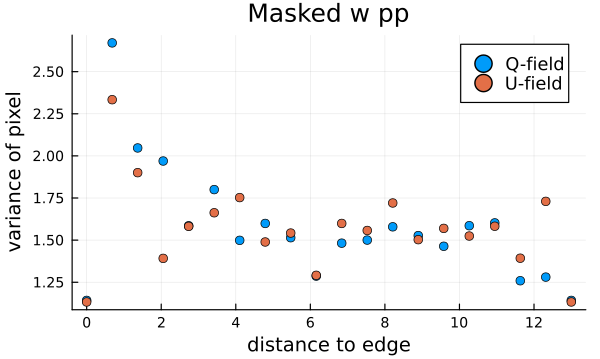

In [42]:
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_masked_pp_vars_q), range(0,13,length=20)).weights
hist_vars_q ./= fit(Histogram, vec(dist_mat), Weights(ones(length(_masked_pp_vars_q))), range(0,13,length=20)).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_masked_pp_vars_u), range(0,13,length=20)).weights
hist_vars_u ./= fit(Histogram, vec(dist_mat), Weights(ones(length(_masked_pp_vars_q))), range(0,13,length=20)).weights
plot(0.0:0.6842105263157895:13.0, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field",
     title="Masked w pp")
plot!(0.0:0.6842105263157895:13.0, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field")

## Comp

In [27]:
# Unmasked
esspc_unmasked_mchmc = MCMCDiagnosticTools.ess(unmasked_mchmc_chain)[[:r,:Aϕ],:ess]/10_000

esss_unmasked_hmc, _ = MicroCanonicalHMC.Summarize(unmasked_hmc_samples)
esspc_unmasked_hmc = esss_unmasked_hmc[end-1:end] ./ 28_000

esspc_unmasked_muse = 0.006

# Masked
esspc_masked_mchmc = MCMCDiagnosticTools.ess(masked_mchmc_chain)[[:r,:Aϕ],:ess]/10_000
esspc_masked_pp_mchmc = MCMCDiagnosticTools.ess(masked_pp_mchmc_chain)[[:r,:Aϕ],:ess]/10_000

esss_masked_hmc, _ = MicroCanonicalHMC.Summarize(masked_hmc_samples)
esspc_masked_hmc = esss_masked_hmc[end-1:end] ./ 28_000

esspc_masked_muse = 0.006;

In [28]:
# Unmasked
esss_unmasked_no_cosmo_mchmc, _  = MicroCanonicalHMC.Summarize(unmasked_no_cosmo_mchmc_chain)
esspc_unmasked_no_cosmo_mchmc = mean(esss_unmasked_no_cosmo_mchmc) ./ 10_000

esss_unmasked_no_cosmo_hmc, _  = MicroCanonicalHMC.Summarize(unmasked_no_cosmo_hmc_chain)
esspc_unmasked_no_cosmo_hmc = mean(esss_unmasked_no_cosmo_hmc) ./ 28_000

# Masked
esss_masked_no_cosmo_mchmc, _  = MicroCanonicalHMC.Summarize(masked_no_cosmo_mchmc_chain)
esspc_masked_no_cosmo_mchmc = mean(esss_masked_no_cosmo_mchmc) ./ 10_000

esss_masked_pp_no_cosmo_mchmc, _  = MicroCanonicalHMC.Summarize(masked_pp_no_cosmo_mchmc_chain)
esspc_masked_pp_no_cosmo_mchmc = mean(esss_masked_pp_no_cosmo_mchmc) ./ 10_000

esss_masked_no_cosmo_hmc, _ = MicroCanonicalHMC.Summarize(masked_no_cosmo_hmc_chain)
esspc_masked_no_cosmo_hmc = mean(esss_masked_no_cosmo_hmc) ./ 28_000;

0.0021645172975800543

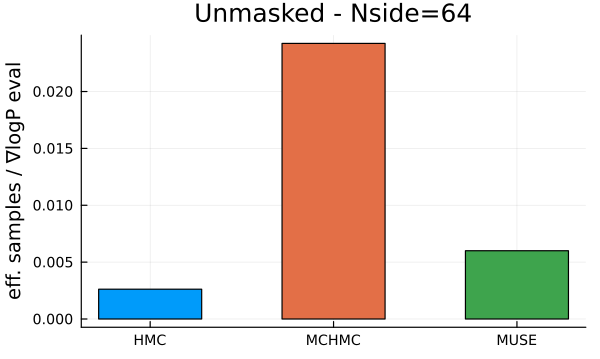

In [29]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(["HMC" "MCHMC" "MUSE"], which_ess.([[esspc_unmasked_hmc] [esspc_unmasked_mchmc] [esspc_unmasked_muse]]),
     ylabel = "eff. samples / ∇logP eval", legend=false, title="Unmasked - Nside=64")

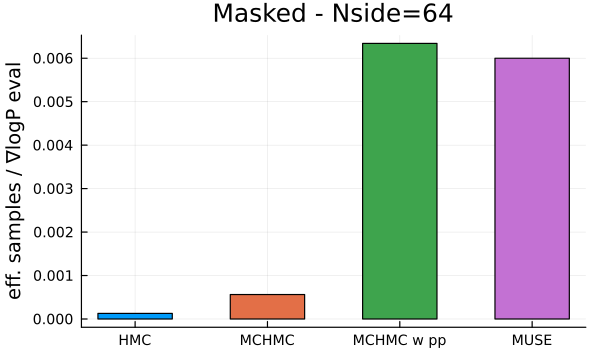

In [30]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(["HMC" "MCHMC" "MCHMC w pp" "MUSE"], which_ess.([[esspc_masked_hmc] [esspc_masked_mchmc] [esspc_masked_pp_mchmc] [esspc_masked_muse]]),
     ylabel = "eff. samples / ∇logP eval", legend=false, title="Masked - Nside=64")

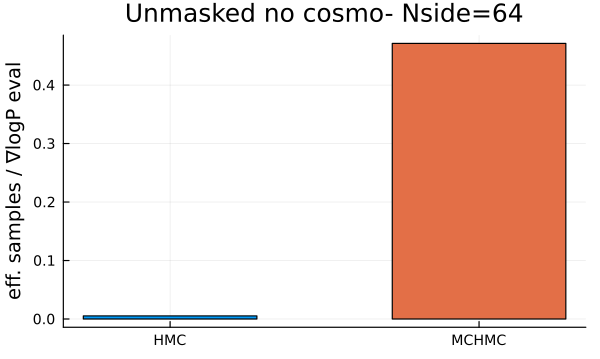

In [44]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(["HMC" "MCHMC"], which_ess.([[esspc_unmasked_no_cosmo_hmc] [[esspc_unmasked_no_cosmo_mchmc]]]),
     ylabel = "eff. samples / ∇logP eval", legend=false, title="Unmasked no cosmo- Nside=64")

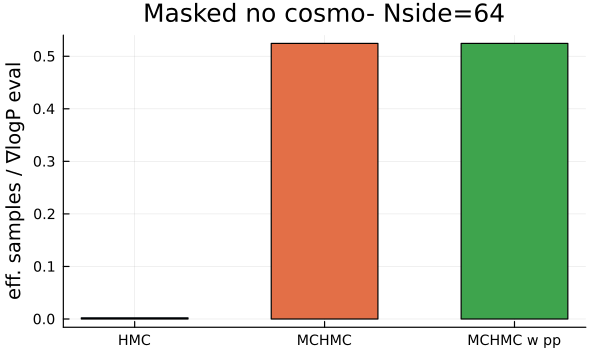

In [32]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(["HMC" "MCHMC" "MCHMC w pp"], which_ess.([[esspc_masked_no_cosmo_hmc] [esspc_masked_no_cosmo_mchmc] [esspc_masked_no_cosmo_mchmc]]),
     ylabel = "eff. samples / ∇logP eval", legend=false, title="Masked no cosmo- Nside=64")

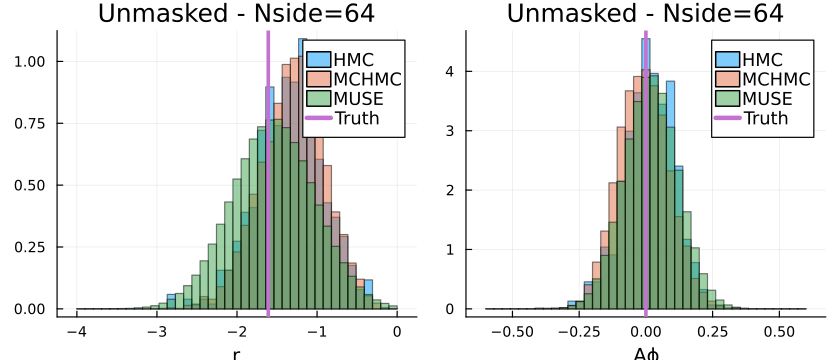

In [33]:
plot(
    begin
        histogram(unmasked_hmc_samples[:, end-1], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC", xlabel="r")
        histogram!(log.(unmasked_mchmc_chain[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(unmasked_muse_chain[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(unmasked_hmc_samples[:, end], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC", xlabel="Aϕ")
        histogram!(log.(unmasked_mchmc_chain[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(unmasked_muse_chain[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300),
    title="Unmasked - Nside=64")

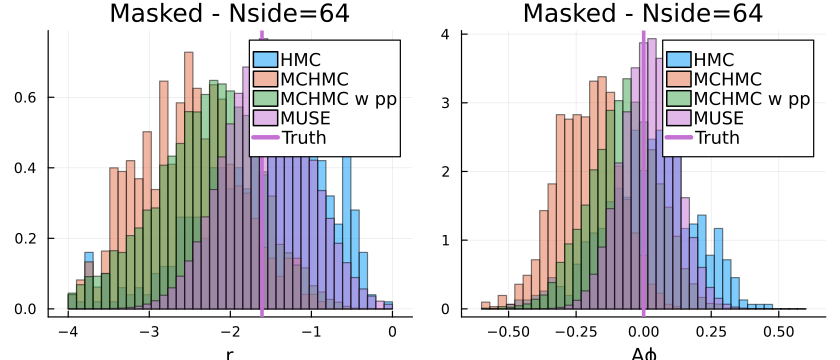

In [34]:
plot(
    begin
        histogram(masked_hmc_samples[:, end-1], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC", xlabel="r")
        histogram!(log.(masked_mchmc_chain[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(log.(masked_pp_mchmc_chain[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC w pp")
        histogram!(masked_muse_chain[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(masked_hmc_samples[:, end], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC", xlabel="Aϕ")
        histogram!(log.(masked_mchmc_chain[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(log.(masked_pp_mchmc_chain[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC w pp")
        histogram!(masked_muse_chain[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300),
    title="Masked - Nside=64")